In [1]:
import pymysql
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline

In [2]:
host = '127.0.0.1'
port = "3306"
user = 'root'
password = 'dias'
database = 'gdeltindo'

conn = pymysql.connect(
    host=host,
    port=int(port),
    user=user,
    passwd=password,
    db=database,
    charset='utf8mb4')

def run(sql):
    df = pd.read_sql_query(sql,conn)
    return df

In [3]:
AHOK = run("""
SELECT
	t1.SQLDATE,
	avg(t1.GoldsteinScale) AS AvgGI,
	stddev(t1.GoldsteinScale) AS StdGI,
	sum(
		t1.GoldsteinScale * t1.NumMentions
	) / count(*) AS GII,
	avg(t1.AvgTone - t2.GrandMean) AS Norm_AvgTone,
	sum(
		(t1.AvgTone - t2.GrandMean) * t1.NumMentions
	) / count(*) AS Norm_AvgToneImpact,
	stddev(t1.AvgTone) AS Std_AvgTone,
	stddev(t1.AvgTone - t2.GrandMean) AS Norm_Std_AvgTone,
	(
		t3.Sum_PositiveMentions * 1.0
	) / sum(NumMentions) AS PCTPositive,
	(
		t4.Sum_NegativeMentions * 1.0
	) / sum(NumMentions) AS PCTNegative,
	(t5.Sum_NeutralMentions * 1.0) / sum(NumMentions) AS PCTNeutral
FROM
	test t1
LEFT JOIN (
	SELECT
		SQLDATE,
		avg(AvgTone) AS GrandMean
	FROM
		test
	GROUP BY
		SQLDATE
) t2 ON t1.SQLDATE = t2.SQLDATE
LEFT JOIN (
	SELECT
		SQLDATE,
		sum(NumMentions) AS Sum_PositiveMentions
	FROM
		test
	WHERE
		AvgTone > 0
	GROUP BY
		SQLDATE
) t3 ON t1.SQLDATE = t3.SQLDATE
LEFT JOIN (
	SELECT
		SQLDATE,
		sum(NumMentions) AS Sum_NegativeMentions
	FROM
		test
	WHERE
		AvgTone < 0
	GROUP BY
		SQLDATE
) t4 ON t1.SQLDATE = t4.SQLDATE
LEFT JOIN (
	SELECT
		SQLDATE,
		sum(NumMentions) AS Sum_NeutralMentions
	FROM
		test
	WHERE
		AvgTone = 0
	GROUP BY
		MonthYear
) t5 ON t1.SQLDATE = t5.SQLDATE
WHERE
	(t1.SQLDATE >= 20160901)
AND (t1.SQLDATE <= 20170601)
GROUP BY
	t1.SQLDATE
ORDER BY
	t1.SQLDATE
""")

In [4]:
AHOK.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 274 entries, 0 to 273
Data columns (total 11 columns):
SQLDATE               274 non-null object
AvgGI                 274 non-null float64
StdGI                 274 non-null float64
GII                   274 non-null float64
Norm_AvgTone          274 non-null float64
Norm_AvgToneImpact    274 non-null float64
Std_AvgTone           274 non-null float64
Norm_Std_AvgTone      274 non-null float64
PCTPositive           274 non-null float64
PCTNegative           274 non-null float64
PCTNeutral            10 non-null float64
dtypes: float64(10), object(1)
memory usage: 22.5+ KB


In [5]:
AHOK['SQLDATE'] = AHOK.SQLDATE.astype(int)

In [6]:
AHOK.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 274 entries, 0 to 273
Data columns (total 11 columns):
SQLDATE               274 non-null int32
AvgGI                 274 non-null float64
StdGI                 274 non-null float64
GII                   274 non-null float64
Norm_AvgTone          274 non-null float64
Norm_AvgToneImpact    274 non-null float64
Std_AvgTone           274 non-null float64
Norm_Std_AvgTone      274 non-null float64
PCTPositive           274 non-null float64
PCTNegative           274 non-null float64
PCTNeutral            10 non-null float64
dtypes: float64(10), int32(1)
memory usage: 22.5 KB


In [7]:
AHOK = AHOK.fillna(0)

In [8]:
AHOK.head()

,SQLDATE,AvgGI,StdGI,GII,Norm_AvgTone,Norm_AvgToneImpact,Std_AvgTone,Norm_Std_AvgTone,PCTPositive,PCTNegative,PCTNeutral
0,20160901,0.715290,4.372706,0.809139,-4.856494e-15,-1.156400,4.052910,4.052910,0.335322,0.644093,0.482399
1,20160902,0.988926,4.268399,14.490083,-4.090025e-15,0.047665,3.503015,3.503015,0.284456,0.701618,0.000000
2,20160903,1.162108,3.959030,39.442735,-1.201318e-15,-12.828601,3.957853,3.957853,0.183306,0.814356,0.000000
3,20160904,1.059504,3.799208,9.233058,1.546972e-15,-6.109265,3.828994,3.828994,0.396207,0.601686,0.000000
4,20160905,0.623473,4.250645,20.197710,-3.415419e-16,-19.612700,3.764606,3.764606,0.167429,0.831238,0.000000


# SAHAM

In [9]:
saham = pd.read_csv('IHSGAHOK.csv')

In [10]:
saham.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 187 entries, 0 to 186
Data columns (total 7 columns):
Date         187 non-null object
Open         183 non-null float64
High         183 non-null float64
Low          183 non-null float64
Close        183 non-null float64
Adj Close    183 non-null float64
Volume       183 non-null float64
dtypes: float64(6), object(1)
memory usage: 9.5+ KB


In [11]:
saham.isnull().values.any()

True

In [13]:
nan_rows = saham[saham[['Date','Open','High','Low','Close','Adj Close','Volume']].isnull()]

In [15]:
saham.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-08-31,NaN,NaN,NaN,NaN,NaN,NaN
1,2016-09-01,5368.516113,5376.643066,5320.083984,5334.546875,5334.388672,4.574173e+09
2,2016-09-02,5323.573242,5359.909180,5323.041992,5353.460938,5353.302246,4.516986e+09
3,2016-09-05,5378.625000,5396.916992,5347.592773,5356.954102,5356.794922,4.792458e+09
4,2016-09-06,5363.044922,5373.208008,5342.558105,5372.096191,5371.936523,3.992078e+09


In [16]:
saham = saham.drop(saham.index[0])

In [17]:
saham

,Date,Open,High,Low,Close,Adj Close,Volume
1,2016-09-01,5368.516113,5376.643066,5320.083984,5334.546875,5334.388672,4.574173e+09
2,2016-09-02,5323.573242,5359.909180,5323.041992,5353.460938,5353.302246,4.516986e+09
3,2016-09-05,5378.625000,5396.916992,5347.592773,5356.954102,5356.794922,4.792458e+09
4,2016-09-06,5363.044922,5373.208008,5342.558105,5372.096191,5371.936523,3.992078e+09
5,2016-09-07,5382.216797,5393.086914,5357.521973,5381.354004,5381.194336,3.609001e+09
6,2016-09-08,5383.062988,5383.536133,5364.609863,5371.078125,5370.918457,4.013516e+09
7,2016-09-09,5355.342773,5358.506836,5281.916992,5281.916992,5281.759766,4.199782e+09
8,2016-09-13,5266.108887,5268.539063,5211.866211,5215.566895,5215.412109,4.247243e+09
9,2016-09-14,5188.397949,5189.357910,5128.167969,5146.038086,5145.885254,4.923478e+09
10,2016-09-15,5160.748047,5270.488770,5158.727051,5265.818848,5265.662598,4.452144e+09


In [18]:
saham = saham.dropna() 

In [19]:
saham.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 183 entries, 1 to 186
Data columns (total 7 columns):
Date         183 non-null object
Open         183 non-null float64
High         183 non-null float64
Low          183 non-null float64
Close        183 non-null float64
Adj Close    183 non-null float64
Volume       183 non-null float64
dtypes: float64(6), object(1)
memory usage: 10.7+ KB


In [20]:
saham['Date'] = pd.to_numeric(saham.Date.str.replace('-',''))

C:\Users\Dias\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [32]:
saham.to_csv('sahamBersihkoma.csv', sep=',', encoding='utf-8')

In [21]:
saham.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 183 entries, 1 to 186
Data columns (total 7 columns):
Date         183 non-null int64
Open         183 non-null float64
High         183 non-null float64
Low          183 non-null float64
Close        183 non-null float64
Adj Close    183 non-null float64
Volume       183 non-null float64
dtypes: float64(6), int64(1)
memory usage: 11.4 KB


In [22]:
saham.head()

,Date,Open,High,Low,Close,Adj Close,Volume
1,20160901,5368.516113,5376.643066,5320.083984,5334.546875,5334.388672,4.574173e+09
2,20160902,5323.573242,5359.909180,5323.041992,5353.460938,5353.302246,4.516986e+09
3,20160905,5378.625000,5396.916992,5347.592773,5356.954102,5356.794922,4.792458e+09
4,20160906,5363.044922,5373.208008,5342.558105,5372.096191,5371.936523,3.992078e+09
5,20160907,5382.216797,5393.086914,5357.521973,5381.354004,5381.194336,3.609001e+09


In [23]:
 result = pd.concat([AHOK, saham], axis=1, join='inner')

In [24]:
result

,SQLDATE,AvgGI,StdGI,GII,Norm_AvgTone,Norm_AvgToneImpact,Std_AvgTone,Norm_Std_AvgTone,PCTPositive,PCTNegative,PCTNeutral,Date,Open,High,Low,Close,Adj Close,Volume
1,20160902,0.988926,4.268399,14.490083,-4.090025e-15,0.047665,3.503015,3.503015,0.284456,0.701618,0.000000,20160901,5368.516113,5376.643066,5320.083984,5334.546875,5334.388672,4.574173e+09
2,20160903,1.162108,3.959030,39.442735,-1.201318e-15,-12.828601,3.957853,3.957853,0.183306,0.814356,0.000000,20160902,5323.573242,5359.909180,5323.041992,5353.460938,5353.302246,4.516986e+09
3,20160904,1.059504,3.799208,9.233058,1.546972e-15,-6.109265,3.828994,3.828994,0.396207,0.601686,0.000000,20160905,5378.625000,5396.916992,5347.592773,5356.954102,5356.794922,4.792458e+09
4,20160905,0.623473,4.250645,20.197710,-3.415419e-16,-19.612700,3.764606,3.764606,0.167429,0.831238,0.000000,20160906,5363.044922,5373.208008,5342.558105,5372.096191,5371.936523,3.992078e+09
5,20160906,0.339369,4.492788,-4.146678,-1.006762e-14,-10.634688,3.629492,3.629492,0.140017,0.858241,0.000000,20160907,5382.216797,5393.086914,5357.521973,5381.354004,5381.194336,3.609001e+09
6,20160907,0.283897,4.839505,20.147903,-3.061151e-15,-8.716695,3.283762,3.283762,0.108789,0.888184,0.000000,20160908,5383.062988,5383.536133,5364.609863,5371.078125,5370.918457,4.013516e+09
7,20160908,0.885299,3.854292,26.823425,-2.057231e-15,-4.093838,3.497136,3.497136,0.111258,0.878529,0.000000,20160909,5355.342773,5358.506836,5281.916992,5281.916992,5281.759766,4.199782e+09
8,20160909,1.211606,4.167627,9.188863,3.002939e-15,-16.042608,3.943174,3.943174,0.150680,0.837646,0.000000,20160913,5266.108887,5268.539063,5211.866211,5215.566895,5215.412109,4.247243e+09
9,20160910,0.746849,4.703772,7.180042,-1.502999e-15,-7.157034,3.796414,3.796414,0.187632,0.803383,0.000000,20160914,5188.397949,5189.357910,5128.167969,5146.038086,5145.885254,4.923478e+09
10,20160911,0.314655,4.161018,5.746552,-1.170201e-15,-0.380294,3.787200,3.787200,0.172540,0.825465,0.000000,20160915,5160.748047,5270.488770,5158.727051,5265.818848,5265.662598,4.452144e+09


In [25]:
result.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 183 entries, 1 to 186
Data columns (total 18 columns):
SQLDATE               183 non-null int32
AvgGI                 183 non-null float64
StdGI                 183 non-null float64
GII                   183 non-null float64
Norm_AvgTone          183 non-null float64
Norm_AvgToneImpact    183 non-null float64
Std_AvgTone           183 non-null float64
Norm_Std_AvgTone      183 non-null float64
PCTPositive           183 non-null float64
PCTNegative           183 non-null float64
PCTNeutral            183 non-null float64
Date                  183 non-null int64
Open                  183 non-null float64
High                  183 non-null float64
Low                   183 non-null float64
Close                 183 non-null float64
Adj Close             183 non-null float64
Volume                183 non-null float64
dtypes: float64(16), int32(1), int64(1)
memory usage: 26.4 KB


In [26]:
result.corr()

,SQLDATE,AvgGI,StdGI,GII,Norm_AvgTone,Norm_AvgToneImpact,Std_AvgTone,Norm_Std_AvgTone,PCTPositive,PCTNegative,PCTNeutral,Date,Open,High,Low,Close,Adj Close,Volume
SQLDATE,1.000000,0.158356,-0.247971,0.181601,-0.102471,0.171025,-0.411671,-0.411671,0.053686,-0.046250,-0.015180,0.700962,0.767159,0.770289,0.772214,0.773432,0.773550,-0.486821
AvgGI,0.158356,1.000000,-0.736492,0.698702,0.099844,0.379535,-0.306228,-0.306228,0.457556,-0.469747,0.101824,-0.125389,0.209075,0.204653,0.198182,0.191876,0.191780,0.316855
StdGI,-0.247971,-0.736492,1.000000,-0.497294,-0.044668,-0.343775,0.281043,0.281043,-0.429429,0.438586,-0.081840,0.053031,-0.246332,-0.230615,-0.243093,-0.220776,-0.220729,-0.148666
GII,0.181601,0.698702,-0.497294,1.000000,0.176913,0.642890,-0.407738,-0.407738,0.309097,-0.318152,0.119318,-0.066226,0.121959,0.113703,0.126517,0.112387,0.112301,0.210514
Norm_AvgTone,-0.102471,0.099844,-0.044668,0.176913,1.000000,0.109400,-0.090049,-0.090049,0.038027,-0.043643,0.027470,-0.101216,-0.142995,-0.123230,-0.123917,-0.115196,-0.115195,0.048473
Norm_AvgToneImpact,0.171025,0.379535,-0.343775,0.642890,0.109400,1.000000,-0.387500,-0.387500,0.528004,-0.538032,0.021562,-0.007667,0.095694,0.084296,0.107287,0.088025,0.087979,0.096829
Std_AvgTone,-0.411671,-0.306228,0.281043,-0.407738,-0.090049,-0.387500,1.000000,1.000000,0.070751,-0.066719,-0.138408,-0.250553,-0.239543,-0.220674,-0.250353,-0.231469,-0.231455,0.098438
Norm_Std_AvgTone,-0.411671,-0.306228,0.281043,-0.407738,-0.090049,-0.387500,1.000000,1.000000,0.070751,-0.066719,-0.138408,-0.250553,-0.239543,-0.220674,-0.250353,-0.231469,-0.231455,0.098438
PCTPositive,0.053686,0.457556,-0.429429,0.309097,0.038027,0.528004,0.070751,0.070751,1.000000,-0.989561,-0.035620,-0.111403,0.228695,0.223444,0.221946,0.216172,0.216133,0.174712
PCTNegative,-0.046250,-0.469747,0.438586,-0.318152,-0.043643,-0.538032,-0.066719,-0.066719,-0.989561,1.000000,0.030463,0.125506,-0.216252,-0.209730,-0.206604,-0.199121,-0.199085,-0.176692


In [28]:
result = result.drop('Date', axis=1)

In [29]:
result.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 183 entries, 1 to 186
Data columns (total 17 columns):
SQLDATE               183 non-null int32
AvgGI                 183 non-null float64
StdGI                 183 non-null float64
GII                   183 non-null float64
Norm_AvgTone          183 non-null float64
Norm_AvgToneImpact    183 non-null float64
Std_AvgTone           183 non-null float64
Norm_Std_AvgTone      183 non-null float64
PCTPositive           183 non-null float64
PCTNegative           183 non-null float64
PCTNeutral            183 non-null float64
Open                  183 non-null float64
High                  183 non-null float64
Low                   183 non-null float64
Close                 183 non-null float64
Adj Close             183 non-null float64
Volume                183 non-null float64
dtypes: float64(16), int32(1)
memory usage: 25.0 KB


In [30]:
result.corr()

,SQLDATE,AvgGI,StdGI,GII,Norm_AvgTone,Norm_AvgToneImpact,Std_AvgTone,Norm_Std_AvgTone,PCTPositive,PCTNegative,PCTNeutral,Open,High,Low,Close,Adj Close,Volume
SQLDATE,1.000000,0.158356,-0.247971,0.181601,-0.102471,0.171025,-0.411671,-0.411671,0.053686,-0.046250,-0.015180,0.767159,0.770289,0.772214,0.773432,0.773550,-0.486821
AvgGI,0.158356,1.000000,-0.736492,0.698702,0.099844,0.379535,-0.306228,-0.306228,0.457556,-0.469747,0.101824,0.209075,0.204653,0.198182,0.191876,0.191780,0.316855
StdGI,-0.247971,-0.736492,1.000000,-0.497294,-0.044668,-0.343775,0.281043,0.281043,-0.429429,0.438586,-0.081840,-0.246332,-0.230615,-0.243093,-0.220776,-0.220729,-0.148666
GII,0.181601,0.698702,-0.497294,1.000000,0.176913,0.642890,-0.407738,-0.407738,0.309097,-0.318152,0.119318,0.121959,0.113703,0.126517,0.112387,0.112301,0.210514
Norm_AvgTone,-0.102471,0.099844,-0.044668,0.176913,1.000000,0.109400,-0.090049,-0.090049,0.038027,-0.043643,0.027470,-0.142995,-0.123230,-0.123917,-0.115196,-0.115195,0.048473
Norm_AvgToneImpact,0.171025,0.379535,-0.343775,0.642890,0.109400,1.000000,-0.387500,-0.387500,0.528004,-0.538032,0.021562,0.095694,0.084296,0.107287,0.088025,0.087979,0.096829
Std_AvgTone,-0.411671,-0.306228,0.281043,-0.407738,-0.090049,-0.387500,1.000000,1.000000,0.070751,-0.066719,-0.138408,-0.239543,-0.220674,-0.250353,-0.231469,-0.231455,0.098438
Norm_Std_AvgTone,-0.411671,-0.306228,0.281043,-0.407738,-0.090049,-0.387500,1.000000,1.000000,0.070751,-0.066719,-0.138408,-0.239543,-0.220674,-0.250353,-0.231469,-0.231455,0.098438
PCTPositive,0.053686,0.457556,-0.429429,0.309097,0.038027,0.528004,0.070751,0.070751,1.000000,-0.989561,-0.035620,0.228695,0.223444,0.221946,0.216172,0.216133,0.174712
PCTNegative,-0.046250,-0.469747,0.438586,-0.318152,-0.043643,-0.538032,-0.066719,-0.066719,-0.989561,1.000000,0.030463,-0.216252,-0.209730,-0.206604,-0.199121,-0.199085,-0.176692


In [34]:
pct = run("""SELECT * FROM hlpctpctchange""")

In [35]:
pct.head()

,Date,HLPCT,PCTCHANGE
0,20160901,0.010631238561289382,-0.00632749111393057
1,20160902,0.006925962270334699,0.0056142171134610595
2,20160905,0.00922363034990978,-0.004029077691789147
3,20160906,0.0057369339551618295,0.0016877108306271973
4,20160907,0.006638319204146089,-0.0001603043936247888


In [36]:
hasil = pd.concat([result, pct], axis=1, join='inner')

In [37]:
hasil.head()

,SQLDATE,AvgGI,StdGI,GII,Norm_AvgTone,Norm_AvgToneImpact,Std_AvgTone,Norm_Std_AvgTone,PCTPositive,PCTNegative,PCTNeutral,Open,High,Low,Close,Adj Close,Volume,Date,HLPCT,PCTCHANGE
1,20160902,0.988926,4.268399,14.490083,-4.090025e-15,0.047665,3.503015,3.503015,0.284456,0.701618,0.0,5368.516113,5376.643066,5320.083984,5334.546875,5334.388672,4.574173e+09,20160902,0.006925962270334699,0.0056142171134610595
2,20160903,1.162108,3.959030,39.442735,-1.201318e-15,-12.828601,3.957853,3.957853,0.183306,0.814356,0.0,5323.573242,5359.909180,5323.041992,5353.460938,5353.302246,4.516986e+09,20160905,0.00922363034990978,-0.004029077691789147
3,20160904,1.059504,3.799208,9.233058,1.546972e-15,-6.109265,3.828994,3.828994,0.396207,0.601686,0.0,5378.625000,5396.916992,5347.592773,5356.954102,5356.794922,4.792458e+09,20160906,0.0057369339551618295,0.0016877108306271973
4,20160905,0.623473,4.250645,20.197710,-3.415419e-16,-19.612700,3.764606,3.764606,0.167429,0.831238,0.0,5363.044922,5373.208008,5342.558105,5372.096191,5371.936523,3.992078e+09,20160907,0.006638319204146089,-0.0001603043936247888
5,20160906,0.339369,4.492788,-4.146678,-1.006762e-14,-10.634688,3.629492,3.629492,0.140017,0.858241,0.0,5382.216797,5393.086914,5357.521973,5381.354004,5381.194336,3.609001e+09,20160908,0.003527986281077868,-0.0022264021481296823


In [38]:
hasil = hasil.drop('Date', axis=1)

In [39]:
hasil.head()

,SQLDATE,AvgGI,StdGI,GII,Norm_AvgTone,Norm_AvgToneImpact,Std_AvgTone,Norm_Std_AvgTone,PCTPositive,PCTNegative,PCTNeutral,Open,High,Low,Close,Adj Close,Volume,HLPCT,PCTCHANGE
1,20160902,0.988926,4.268399,14.490083,-4.090025e-15,0.047665,3.503015,3.503015,0.284456,0.701618,0.0,5368.516113,5376.643066,5320.083984,5334.546875,5334.388672,4.574173e+09,0.006925962270334699,0.0056142171134610595
2,20160903,1.162108,3.959030,39.442735,-1.201318e-15,-12.828601,3.957853,3.957853,0.183306,0.814356,0.0,5323.573242,5359.909180,5323.041992,5353.460938,5353.302246,4.516986e+09,0.00922363034990978,-0.004029077691789147
3,20160904,1.059504,3.799208,9.233058,1.546972e-15,-6.109265,3.828994,3.828994,0.396207,0.601686,0.0,5378.625000,5396.916992,5347.592773,5356.954102,5356.794922,4.792458e+09,0.0057369339551618295,0.0016877108306271973
4,20160905,0.623473,4.250645,20.197710,-3.415419e-16,-19.612700,3.764606,3.764606,0.167429,0.831238,0.0,5363.044922,5373.208008,5342.558105,5372.096191,5371.936523,3.992078e+09,0.006638319204146089,-0.0001603043936247888
5,20160906,0.339369,4.492788,-4.146678,-1.006762e-14,-10.634688,3.629492,3.629492,0.140017,0.858241,0.0,5382.216797,5393.086914,5357.521973,5381.354004,5381.194336,3.609001e+09,0.003527986281077868,-0.0022264021481296823


In [41]:
hasil.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 179 entries, 1 to 182
Data columns (total 19 columns):
SQLDATE               179 non-null int32
AvgGI                 179 non-null float64
StdGI                 179 non-null float64
GII                   179 non-null float64
Norm_AvgTone          179 non-null float64
Norm_AvgToneImpact    179 non-null float64
Std_AvgTone           179 non-null float64
Norm_Std_AvgTone      179 non-null float64
PCTPositive           179 non-null float64
PCTNegative           179 non-null float64
PCTNeutral            179 non-null float64
Open                  179 non-null float64
High                  179 non-null float64
Low                   179 non-null float64
Close                 179 non-null float64
Adj Close             179 non-null float64
Volume                179 non-null float64
HLPCT                 179 non-null object
PCTCHANGE             179 non-null object
dtypes: float64(16), int32(1), object(2)
memory usage: 25.9+ KB


In [42]:
hasil['HLPCT'] = hasil.HLPCT.astype(float)
hasil['PCTCHANGE'] =hasil.PCTCHANGE.astype(float)
hasil.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 179 entries, 1 to 182
Data columns (total 19 columns):
SQLDATE               179 non-null int32
AvgGI                 179 non-null float64
StdGI                 179 non-null float64
GII                   179 non-null float64
Norm_AvgTone          179 non-null float64
Norm_AvgToneImpact    179 non-null float64
Std_AvgTone           179 non-null float64
Norm_Std_AvgTone      179 non-null float64
PCTPositive           179 non-null float64
PCTNegative           179 non-null float64
PCTNeutral            179 non-null float64
Open                  179 non-null float64
High                  179 non-null float64
Low                   179 non-null float64
Close                 179 non-null float64
Adj Close             179 non-null float64
Volume                179 non-null float64
HLPCT                 179 non-null float64
PCTCHANGE             179 non-null float64
dtypes: float64(18), int32(1)
memory usage: 27.3 KB


In [78]:
hasil[["Norm_AvgToneImpact", 'PCTCHANGE']].corr()

,Norm_AvgToneImpact,PCTCHANGE
Norm_AvgToneImpact,1.000000,-0.082537
PCTCHANGE,-0.082537,1.000000


In [74]:
hasil['SQLDATE'] = hasil.SQLDATE.astype(int)

In [75]:
hasil.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 179 entries, 1 to 182
Data columns (total 19 columns):
SQLDATE               179 non-null int32
AvgGI                 179 non-null float64
StdGI                 179 non-null float64
GII                   179 non-null float64
Norm_AvgTone          179 non-null float64
Norm_AvgToneImpact    179 non-null float64
Std_AvgTone           179 non-null float64
Norm_Std_AvgTone      179 non-null float64
PCTPositive           179 non-null float64
PCTNegative           179 non-null float64
PCTNeutral            179 non-null float64
Open                  179 non-null float64
High                  179 non-null float64
Low                   179 non-null float64
Close                 179 non-null float64
Adj Close             179 non-null float64
Volume                179 non-null float64
HLPCT                 179 non-null float64
PCTCHANGE             179 non-null float64
dtypes: float64(18), int32(1)
memory usage: 27.3 KB


In [53]:
FractionMonth = hasil.SQLDATE.str[0:4].astype('int64') + hasil.SQLDATE.str[4:6].astype('int64') / 12 + hasil.SQLDATE.str[6:7].astype('int64') 
print(FractionMonth)

1      2016.750000
2      2016.750000
3      2016.750000
4      2016.750000
5      2016.750000
6      2016.750000
7      2016.750000
8      2016.750000
9      2017.750000
10     2017.750000
11     2017.750000
12     2017.750000
13     2017.750000
14     2017.750000
15     2017.750000
16     2017.750000
17     2017.750000
18     2017.750000
19     2018.750000
20     2018.750000
21     2018.750000
22     2018.750000
23     2018.750000
24     2018.750000
25     2018.750000
26     2018.750000
27     2018.750000
28     2018.750000
29     2019.750000
30     2016.833333
          ...     
152    2020.083333
153    2017.166667
154    2017.166667
155    2017.166667
156    2017.166667
157    2017.166667
158    2017.166667
159    2017.166667
161    2017.166667
162    2018.166667
163    2018.166667
164    2018.166667
165    2018.166667
166    2018.166667
167    2018.166667
168    2018.166667
169    2018.166667
170    2018.166667
171    2018.166667
172    2019.166667
173    2019.166667
174    2019.

In [59]:
PCTCHANGES = hasil[['SQLDATE', 'PCTCHANGE']]

In [60]:
PCTCHANGES

,SQLDATE,PCTCHANGE
1,20160902,0.005614
2,20160903,-0.004029
3,20160904,0.001688
4,20160905,-0.000160
5,20160906,-0.002226
6,20160907,-0.013711
7,20160908,-0.009598
8,20160909,-0.008164
9,20160910,0.020360
10,20160911,-0.003717


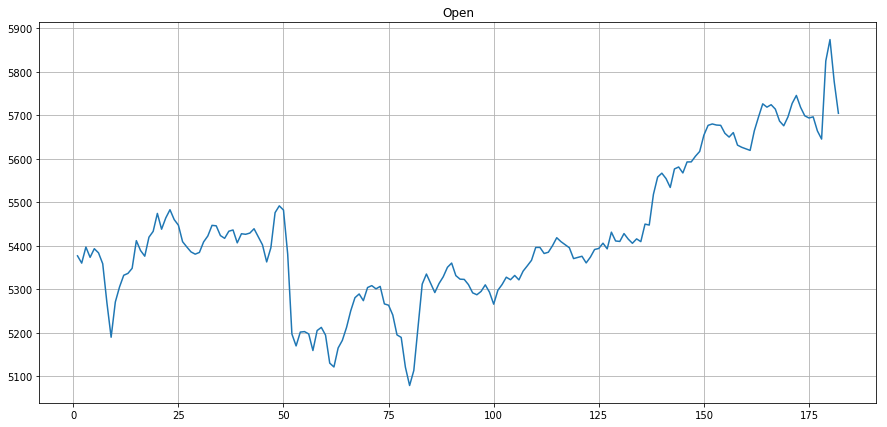

In [87]:
plt.figure(figsize=(15, 7))
plt.plot(hasil.High)
plt.title('Open')
plt.grid(True)
plt.show()


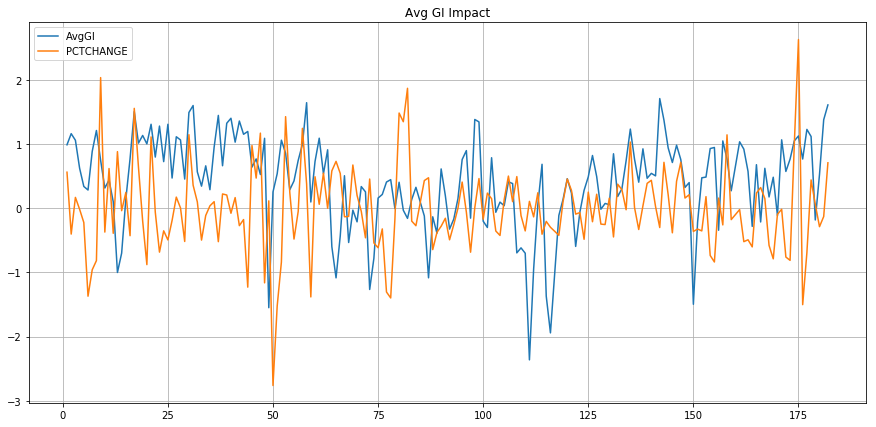

In [99]:
plt.figure(figsize=(15, 7))
plt.plot(hasil.AvgGI)
plt.plot(hasil.PCTCHANGE*100)
plt.title('Avg GI Impact')
plt.grid(True)
plt.legend()
plt.show()

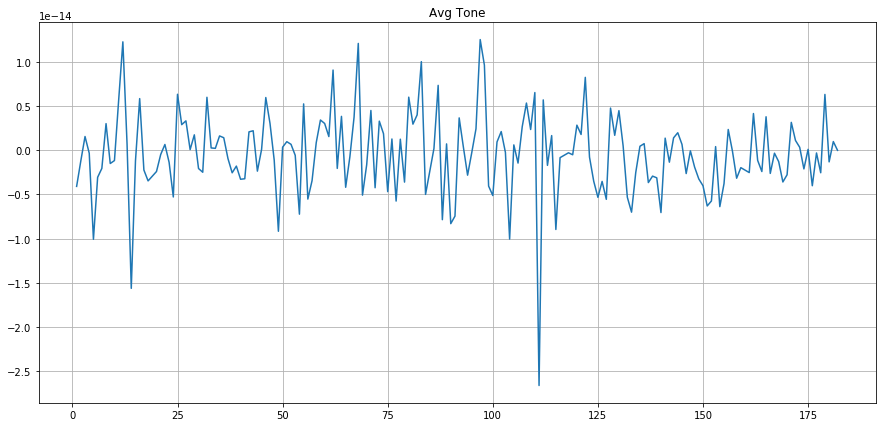

In [94]:
plt.figure(figsize=(15, 7))
plt.plot(hasil.Norm_AvgTone)
plt.title('Avg Tone')
plt.grid(True)
plt.show()